In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('Data_Wind.csv')

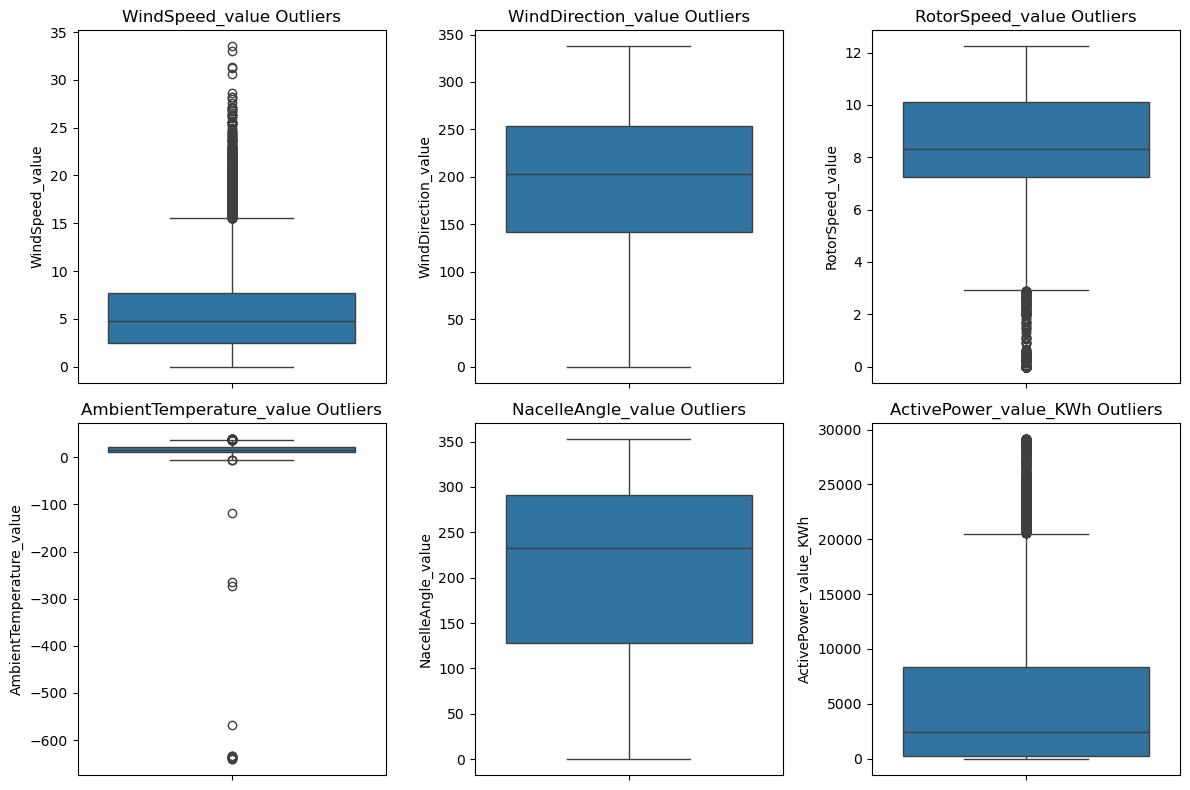

In [28]:
variables = ['WindSpeed_value', 'WindDirection_value', 'RotorSpeed_value', 
             'AmbientTemperature_value', 'NacelleAngle_value', 'ActivePower_value_KWh']

# Boxplot para detectar outliers
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=var)
    plt.title(f'{var} Outliers')
plt.tight_layout()
plt.show()


In [29]:
# 2. Imputar valores atípicos con la media
for var in variables:
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[var] = df[var].apply(lambda x: df[var].mean() if x < lower_bound or x > upper_bound else x)

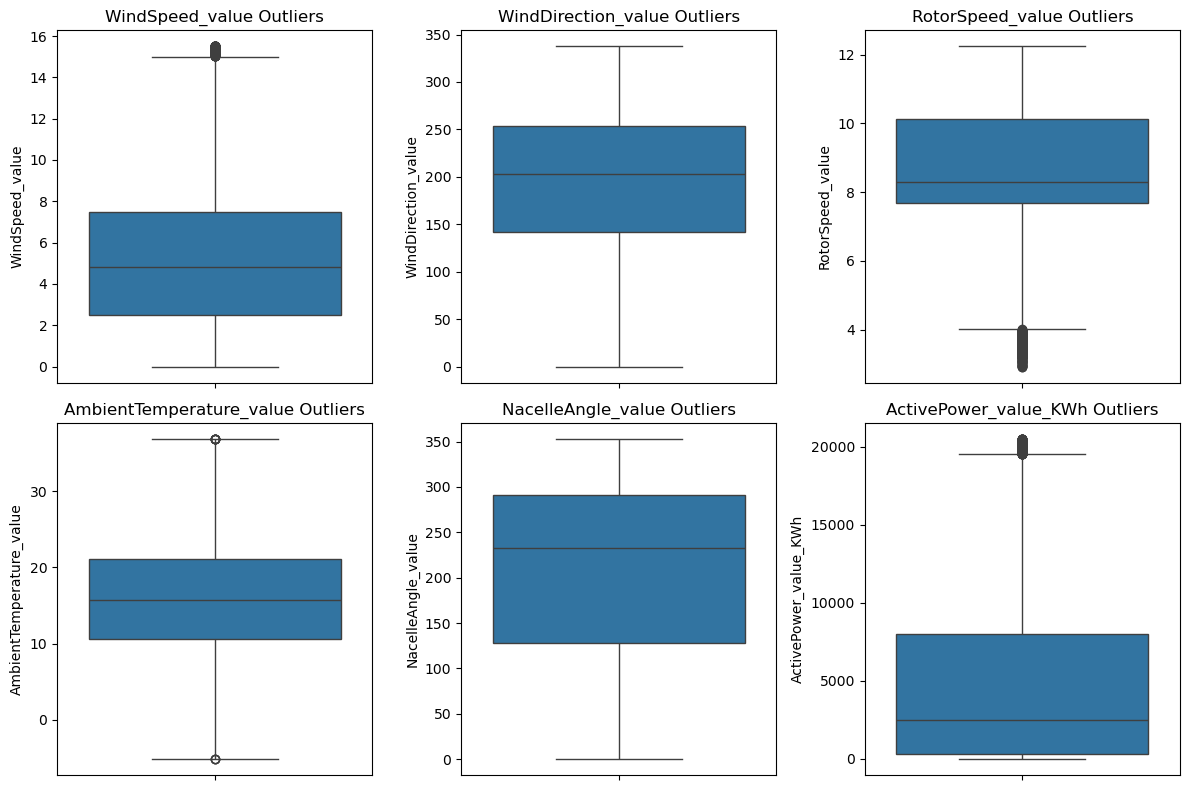

In [30]:
plt.figure(figsize=(12, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, y=var)
    plt.title(f'{var} Outliers')
plt.tight_layout()
plt.show()


In [31]:
#df['index'] = pd.to_datetime(df['index'])
# Ingeniería de características temporales (si tienes una columna de fecha y hora)
#df['month'] = df['index'].dt.month  # Extraer mes
#df['day_of_week'] = df['index'].dt.dayofweek  # Extraer día de la semana
#df['hour'] = df['index'].dt.hour  # Extraer la hora
#df['time_period'] = df['hour'].apply(lambda x: 'Mañana' if 6 <= x < 12 else 'Tarde' if 12 <= x < 18 else 'Noche')

# Ingeniería de interacciones entre variables
df['WindSpeed_Temp'] = df['WindSpeed_value'] * df['AmbientTemperature_value']
df['WindSpeed_squared'] = df['WindSpeed_value'] ** 2
df['RotorSpeed_squared'] = df['RotorSpeed_value'] ** 2

# Convertir la variable 'time_period' en una variable categórica mediante one-hot encoding
#df = pd.get_dummies(df, columns=['time_period'], drop_first=True)


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


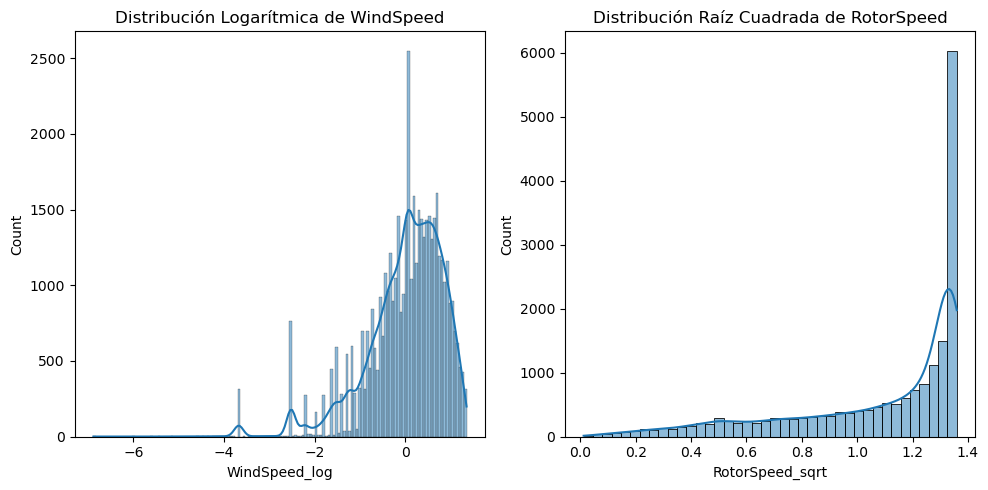

In [32]:
from sklearn.preprocessing import StandardScaler

# Estandarización de las variables seleccionadas
scaler = StandardScaler()
df[['WindSpeed_value', 'RotorSpeed_value', 'AmbientTemperature_value', 'NacelleAngle_value']] = scaler.fit_transform(
    df[['WindSpeed_value', 'RotorSpeed_value', 'AmbientTemperature_value', 'NacelleAngle_value']]
)

# Aplicar transformación logarítmica y raíz cuadrada en variables con sesgo positivo
df['WindSpeed_log'] = np.log1p(df['WindSpeed_value'])  # log(1 + WindSpeed) para evitar log(0)
df['RotorSpeed_sqrt'] = np.sqrt(df['RotorSpeed_value'])  # Raíz cuadrada de RotorSpeed

# Comprobar las distribuciones transformadas
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

# Distribución después de la transformación logarítmica
plt.subplot(1, 2, 1)
sns.histplot(df['WindSpeed_log'], kde=True)
plt.title('Distribución Logarítmica de WindSpeed')

# Distribución después de la transformación raíz cuadrada
plt.subplot(1, 2, 2)
sns.histplot(df['RotorSpeed_sqrt'], kde=True)
plt.title('Distribución Raíz Cuadrada de RotorSpeed')

plt.tight_layout()
plt.show()


In [38]:
# Codificación One-Hot para las variables categóricas
# Si tienes una columna 'site' o 'time_period', aplicamos One-Hot Encoding

# Ejemplo con las columnas 'site' y 'time_period'
#df = pd.get_dummies(df, columns=['site'], drop_first=True)

# Verifica si las columnas 'index' y 'site' existen en el DataFrame antes de eliminarlas
columns_to_drop = ['index', 'site']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Confirma que las columnas han sido eliminadas
print("Columnas después de la eliminación:", df.columns)



Columnas después de la eliminación: Index(['ActivePower_value_KWh', 'AmbientTemperature_value',
       'NacelleAngle_value', 'RotorSpeed_value', 'WindDirection_value',
       'WindSpeed_value'],
      dtype='object')


In [43]:
nulos = df.isnull().sum()

df['WindSpeed_value'] = df['WindSpeed_value'].fillna(df['WindSpeed_value'].mean())

# Mostrar cuántos valores nulos hay por columna
print(nulos)

ActivePower_value_KWh       0
AmbientTemperature_value    0
NacelleAngle_value          0
RotorSpeed_value            0
WindDirection_value         0
WindSpeed_value             0
dtype: int64


In [44]:
# Aplicar PCA después de imputar NaN
from sklearn.decomposition import PCA

# Definir el número de componentes para retener un 95% de la varianza
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(df.drop(['ActivePower_value_KWh'], axis=1))  # Excluye la variable objetivo

# Mostrar la cantidad de componentes retenidos y la varianza explicada
print("Número de componentes retenidos:", pca.n_components_)
print("Varianza explicada por los componentes retenidos:", sum(pca.explained_variance_ratio_))

# Convertir el resultado de PCA en un DataFrame para facilidad
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_pca['ActivePower_value_KWh'] = df['ActivePower_value_KWh'].values  # Añadir la variable objetivo


Número de componentes retenidos: 2
Varianza explicada por los componentes retenidos: 0.992027883857635


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MSE en conjunto de prueba: 23123790.0
MAE en conjunto de prueba: 3468.354248046875


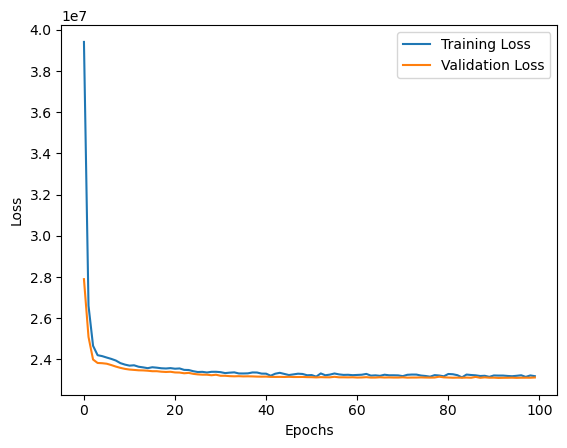

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Dividir los datos en entrenamiento y prueba
X = df_pca.drop('ActivePower_value_KWh', axis=1)  # Características (componentes principales)
y = df_pca['ActivePower_value_KWh']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Escalar los datos (opcional)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Entrenar el modelo con los datos reducidos
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# 4. Evaluar el modelo
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print("MSE en conjunto de prueba:", mse)
print("MAE en conjunto de prueba:", mae)

# Graficar el historial de entrenamiento
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
